# BSC contribution to S2S-AI-challenge

## BSC team and our approach:
We are a team of climate scientists and ML/AI scientists from the Earth Sciences department of the Barcelona Supercomputing Center: Sergi Bech, Llorenç Lledó, Lluís Palma, Andrea Manrique and Carlos Gómez. Learn more about us here: https://ess.bsc.es/

In this notebook we run four different models and combine them to produce a single prediction for 2020:  
   1. Climatology model  
   2. Raw ECMWF model  
   3. Logistic regression with ECMWF ensemble mean as predictor
   4. Random forest with ECMWF members as predictors

The methodology we use is:  
- Train the models in leave-one-year-out cross-validation (LOYO CV), i.e. removing one year for each training iteration. As we have 20 years of hindcast, this is a 20-fold CV.
- Make predictions and compute RPSS using the excluded year for each training iteration.
- Compute the median of RPSS over all training iterations.
- Train again each model using the full hindcast period (2000-2019) and predict 2020.
- Use the cross-validation median RPSS to select the best model at each grid point.

### Resources and runtime
* We have run this notebook in CTE-Power9 machine, a part of Marenostrum4 supercomputer managed by BSC: https://www.bsc.es/es/research-and-development/joint-research-centres/ibm-bsc/news/power9-cluster-more-100-applications
  - platform: CTE-Power9 (local resources)
  - processors requested: 120 CPU
  - available memory: 377,49 GB
  - consumed memory: see section 11
* We hold a copy of the training/obs datasets in our data archive. Please adjust paths in sections 2.1, 2.2, 2.3 as needed to rerun.
* We provide runtimes for some lengthy computations in the code.
* The cross-validation train/predict for random forest (model 4) took around one day with aforementioned configuration. 
* We provide intermediate results for all models as pickle objects to facilitate checks. All intermediate outputs are saved in the execution path. Comment or/and uncomment as needed.

### Safeguards to prevent [overfitting](https://en.wikipedia.org/wiki/Overfitting?wprov=sfti1) 
  - [x] We did not use 2020 observations in training (explicit overfitting and cheating)
  - [x] We did not repeatedly verify my model on 2020 observations and incrementally improved my RPSS (implicit overfitting)
  - [x] We provide RPSS scores for the training period with script `skill_by_year`, see in section 6.3 `predict`.
  - [X] We tried our best to prevent [data leakage](https://en.wikipedia.org/wiki/Leakage_(machine_learning)?wprov=sfti1).
  - [x] We honor the `train-validate-test` [split principle](https://en.wikipedia.org/wiki/Training,_validation,_and_test_sets). This means that the hindcast data is split into `train` and `validate`, whereas `test` is withheld.
  - [x] We did not use `test` explicitly in training or implicitly in incrementally adjusting parameters.
  - [x] We considered [cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)).

### Safeguards for Reproducibility
  - [X] All training data is publicly available (no pre-trained private neural networks, as they are not reproducible for us)
  - [X] Code is well documented, readable and reproducible.
  - [X] Code to reproduce training and predictions is preferred to run within a day on the described architecture. If the training takes longer than a day, please justify why this is needed. Please do not submit training piplelines, which take weeks to train.

# 1 - Startup
### 1.1 Initialize dask client

In [1]:
from dask.distributed import Client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:44953 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 12 Cores: 120 Memory: 377.49 GB


In [2]:
# Chunks used to divide data
chunks={'latitude':10, 'longitude':10, 'year':-1}

### 1.2 Imports

In [3]:
import xarray as xr
import numpy as np
import netCDF4 as nc
import pandas as pd
import pickle
import random
import xskillscore as xs
import cartopy.crs as ccrs
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
import time
import matplotlib as plt

/gpfs/projects/bsc32/bsc32036/opence/lib/python3.8/site-packages/ecmwflibs/__init__.py:133: UserWarning: ecmwflibs universal: cannot find a library called eccodes
  warnings.warn(f"ecmwflibs universal: cannot find a library called {name}")
/gpfs/projects/bsc32/bsc32036/opence/lib/python3.8/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


In [4]:
# Import custom functions from utils.py
from utils import *

# 2 - Load datasets

In [5]:
years = list(range(2000,2020))
variables = ['t2m', 'tp']

### 2.1 Load ECMWF hindcast (2000-2019)

In [6]:
# Get training input data
path_to = '/esarchive/oper/S2S-AI_challenge/data/s2s-ai-challenge-template-master-data-ecmwf_hindcast-input_2000-2019_biweekly_deterministic.zarr/data/'
hind = xr.open_zarr(path_to + 'ecmwf_hindcast-input_2000-2019_biweekly_deterministic.zarr', consolidated=True)

/gpfs/projects/bsc32/bsc32036/opence/lib/python3.8/site-packages/ecmwflibs/__init__.py:133: UserWarning: ecmwflibs universal: cannot find a library called eccodes
  warnings.warn(f"ecmwflibs universal: cannot find a library called {name}")
/gpfs/projects/bsc32/bsc32036/opence/lib/python3.8/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


### 2.2 Load 2020 ECMWF forecasts

In [7]:
# Get 2020 forecast input data
path_to = '/esarchive/oper/S2S-AI_challenge/data/s2s-ai-challenge-template-master-data-ecmwf_forecast-input_2020_biweekly_deterministic.zarr/data/'
forecast = xr.open_zarr(path_to + "ecmwf_forecast-input_2020_biweekly_deterministic.zarr", consolidated=True)

### 2.3 Load and format observations for hindcast period (2000-2019)

In [8]:
# Get observations data corresponding to the 2000-2019 hindcast
path_to = '/esarchive/oper/S2S-AI_challenge/data/s2s-ai-challenge-template-master-data-hindcast-like-observations_2000-2019_biweekly_terciled.zarr/data/'
obs_2000_2019 = xr.open_zarr(path_to + 'hindcast-like-observations_2000-2019_biweekly_terciled.zarr',chunks='auto')

In [9]:
# Split the start dates (forecast_time dim) into year and week dimensions
obs_2000_2019 = year_week_split(obs_2000_2019)

In [10]:
# Convert hot one encoded three category to one array with labels corresponding to each class (0,1,2), for training
obs_2000_2019_train = obs_2000_2019.assign_coords(category=[0, 1, 2])
obs_2000_2019_train = (obs_2000_2019_train * obs_2000_2019_train.category).sum('category')

In [11]:
obs_2000_2019_train

<xarray.Dataset>
Dimensions:     (latitude: 121, lead_time: 2, longitude: 240, year: 20, week: 53)
Coordinates:
  * latitude    (latitude) float64 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
  * lead_time   (lead_time) timedelta64[ns] 14 days 28 days
  * longitude   (longitude) float64 0.0 1.5 3.0 4.5 ... 354.0 355.5 357.0 358.5
    valid_time  (lead_time, year, week) datetime64[ns] dask.array<chunksize=(2, 20, 53), meta=np.ndarray>
  * year        (year) int64 2000 2001 2002 2003 2004 ... 2016 2017 2018 2019
  * week        (week) int64 0 1 2 3 4 5 6 7 8 9 ... 44 45 46 47 48 49 50 51 52
Data variables:
    t2m         (lead_time, latitude, longitude, year, week) float64 dask.array<chunksize=(2, 121, 240, 10, 53), meta=np.ndarray>
    tp          (lead_time, latitude, longitude, year, week) float64 dask.array<chunksize=(2, 121, 240, 10, 53), meta=np.ndarray>

# 3 - Compute forecast/hindcast anomalies
We compute anomalies with respect to a weekly climatology in order to remove temperature/precipitation cycles and train some models using all weeks together.

### 3.1 Hindcast anomalies

In [12]:
hind_reshaped = year_week_split(hind)

In [13]:
hind_climo = hind_reshaped.mean(['year', 'realization'])

In [14]:
hind_anomaly = hind_reshaped - hind_climo

In [15]:
hind_anomaly

<xarray.Dataset>
Dimensions:      (latitude: 121, lead_time: 2, longitude: 240, realization: 11, year: 20, week: 53)
Coordinates:
  * latitude     (latitude) float64 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
  * lead_time    (lead_time) timedelta64[ns] 14 days 28 days
  * longitude    (longitude) float64 0.0 1.5 3.0 4.5 ... 354.0 355.5 357.0 358.5
  * realization  (realization) int64 0 1 2 3 4 5 6 7 8 9 10
    valid_time   (lead_time, year, week) datetime64[ns] dask.array<chunksize=(2, 20, 53), meta=np.ndarray>
  * year         (year) int64 2000 2001 2002 2003 2004 ... 2016 2017 2018 2019
  * week         (week) int64 0 1 2 3 4 5 6 7 8 9 ... 44 45 46 47 48 49 50 51 52
Data variables:
    t2m          (lead_time, realization, latitude, longitude, year, week) float32 dask.array<chunksize=(2, 11, 121, 240, 1, 53), meta=np.ndarray>
    tp           (lead_time, realization, latitude, longitude, year, week) float32 dask.array<chunksize=(2, 11, 121, 240, 1, 53), meta=np.ndarray>

### 3.2 Forecast anomalies with respect to hindcast climatology

In [16]:
# Rename climo dimensions in order to brocadcast and subtract properly
forecast_anomaly = forecast - hind_climo.rename_dims({'week': 'forecast_time'}) 

In [17]:
forecast_anomaly

<xarray.Dataset>
Dimensions:        (forecast_time: 53, latitude: 121, lead_time: 2, longitude: 240, realization: 51)
Coordinates:
  * forecast_time  (forecast_time) datetime64[ns] 2020-01-02 ... 2020-12-31
  * latitude       (latitude) float64 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
  * lead_time      (lead_time) timedelta64[ns] 14 days 28 days
  * longitude      (longitude) float64 0.0 1.5 3.0 4.5 ... 355.5 357.0 358.5
  * realization    (realization) int64 0 1 2 3 4 5 6 7 ... 44 45 46 47 48 49 50
    valid_time     (lead_time, forecast_time) datetime64[ns] dask.array<chunksize=(2, 53), meta=np.ndarray>
    week           (forecast_time) int64 0 1 2 3 4 5 6 ... 46 47 48 49 50 51 52
Data variables:
    t2m            (lead_time, realization, forecast_time, latitude, longitude) float32 dask.array<chunksize=(2, 51, 11, 121, 240), meta=np.ndarray>
    tp             (lead_time, realization, forecast_time, latitude, longitude) float32 dask.array<chunksize=(2, 51, 11, 121, 240), meta=np.ndarray>

# 4 - Climatology (model 1)
Nothing interesting here, just making sure we do not perform worst than climatology.

In [18]:
# Climatology model: 1/3 probability to all categories
clim_p = xr.DataArray([1/3, 1/3, 1/3], dims='category', coords={'category':['below normal', 'near normal', 'above normal']}).to_dataset(name='tp')
clim_p['t2m'] = clim_p['tp']

In [19]:
clim_p

<xarray.Dataset>
Dimensions:   (category: 3)
Coordinates:
  * category  (category) <U12 'below normal' 'near normal' 'above normal'
Data variables:
    tp        (category) float64 0.3333 0.3333 0.3333
    t2m       (category) float64 0.3333 0.3333 0.3333

In [20]:
rpss_clim_lyo = compute_cv_rpss(obs_2000_2019, clim_p, clim_p)

In [21]:
rpss_clim_median = rpss_clim_lyo.median('year')

# 5 - Raw ECMWF forecast (model 2)
This model consists in counting the number of members in each tercile category to set the class probability.

### 5.1 Compute ECMWF hindcast tercile edges and tercile probabilities

In [22]:
hind_reshaped = year_week_split(hind)

In [23]:
edges = hind_reshaped.chunk({'year':-1,'week':-1,'longitude':'auto'}).groupby('week').quantile(q=[1./3.,2./3.], dim=['year','realization']).rename({'quantile':'category_edge'})

In [24]:
hindcast_tercile = make_probabilistic(hind_reshaped, edges)

/gpfs/projects/bsc32/bsc32036/opence/lib/python3.8/site-packages/dask/array/core.py:3949: PerformanceWarning: Increasing number of chunks by factor of 20
  result = blockwise(
/gpfs/projects/bsc32/bsc32036/opence/lib/python3.8/site-packages/dask/array/core.py:3949: PerformanceWarning: Increasing number of chunks by factor of 20
  result = blockwise(
/gpfs/projects/bsc32/bsc32036/opence/lib/python3.8/site-packages/dask/array/core.py:3949: PerformanceWarning: Increasing number of chunks by factor of 20
  result = blockwise(
/gpfs/projects/bsc32/bsc32036/opence/lib/python3.8/site-packages/dask/array/core.py:3949: PerformanceWarning: Increasing number of chunks by factor of 20
  result = blockwise(
/gpfs/projects/bsc32/bsc32036/opence/lib/python3.8/site-packages/dask/array/core.py:3949: PerformanceWarning: Increasing number of chunks by factor of 20
  result = blockwise(
/gpfs/projects/bsc32/bsc32036/opence/lib/python3.8/site-packages/dask/array/core.py:3949: PerformanceWarning: Increasing

In [25]:
# Rename week dimension to forecast_time for consistency with verification scripts
hindcast_tercile = hindcast_tercile.rename({'week': 'forecast_time'})
obs_2000_2019 = obs_2000_2019.rename({'week': 'forecast_time'})

In [26]:
obs_2000_2019.load()
hindcast_tercile.load()

<xarray.Dataset>
Dimensions:        (latitude: 121, lead_time: 2, longitude: 240, year: 20, forecast_time: 53, category: 3)
Coordinates:
  * latitude       (latitude) float64 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
  * lead_time      (lead_time) timedelta64[ns] 14 days 28 days
  * longitude      (longitude) float64 0.0 1.5 3.0 4.5 ... 355.5 357.0 358.5
    valid_time     (lead_time, year, forecast_time) datetime64[ns] 2000-01-16...
  * year           (year) int64 2000 2001 2002 2003 2004 ... 2016 2017 2018 2019
  * forecast_time  (forecast_time) int64 0 1 2 3 4 5 6 ... 46 47 48 49 50 51 52
  * category       (category) <U12 'below normal' 'near normal' 'above normal'
Data variables:
    t2m            (category, lead_time, latitude, longitude, year, forecast_time) float64 ...
    tp             (category, lead_time, latitude, longitude, year, forecast_time) float64 ...

### 5.2 Compute RPSS for each hindcast year

In [27]:
rpss_concat = compute_cv_rpss(obs_2000_2019, hindcast_tercile, clim_p)

In [28]:
rpss_raw_model = rpss_concat.median('year')

/gpfs/projects/bsc32/bsc32036/opence/lib/python3.8/site-packages/xarray/plot/facetgrid.py:394: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()


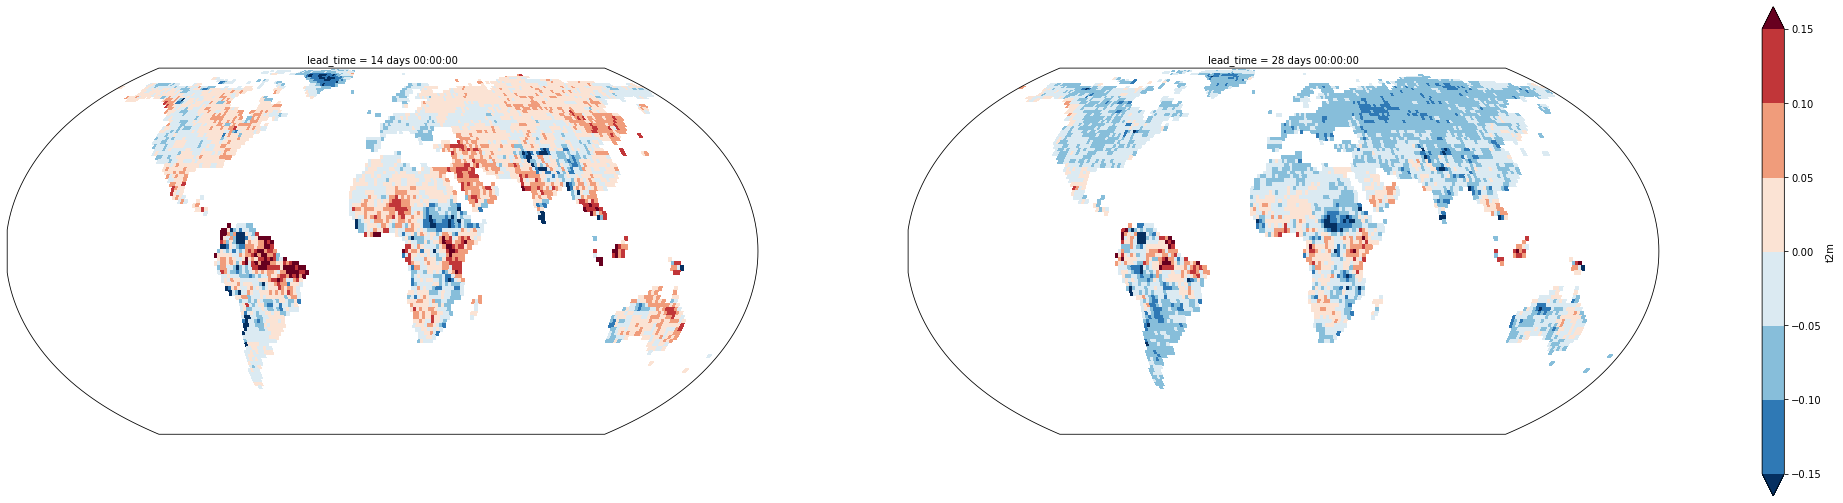

In [29]:
standard_plot(rpss_raw_model.t2m)

### 5.3 Compute 2020 ECMWF tercile probabilities

In [30]:
forecast_rename = forecast.rename({'forecast_time': 'week'})

In [31]:
forecast_rename['week'] = edges['week']

In [32]:
forecast_tercile = make_probabilistic(forecast_rename, edges)

In [33]:
forecast_tercile.load()

<xarray.Dataset>
Dimensions:     (week: 53, latitude: 121, lead_time: 2, longitude: 240, category: 3)
Coordinates:
  * week        (week) int64 0 1 2 3 4 5 6 7 8 9 ... 44 45 46 47 48 49 50 51 52
  * latitude    (latitude) float64 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
  * lead_time   (lead_time) timedelta64[ns] 14 days 28 days
  * longitude   (longitude) float64 0.0 1.5 3.0 4.5 ... 354.0 355.5 357.0 358.5
    valid_time  (lead_time, week) datetime64[ns] 2020-01-16 ... 2021-01-28
  * category    (category) <U12 'below normal' 'near normal' 'above normal'
Data variables:
    t2m         (category, lead_time, week, latitude, longitude) float64 0.31...
    tp          (category, lead_time, week, latitude, longitude) float64 0.25...

# 6 - Logistic regression (model 3)
This simple linear model uses the ECMWF ensemble mean of the target variable as the only predictor.
### 6.0 Define train/predict functions

In [34]:
# Atomic function that trains a logistic regression. 
# It takes one training example of one grid point and the corresponding observations. 
def atomic_function_training_LR(dataset, obs):
    dataset = dataset.reshape(dataset.shape[0]*dataset.shape[1])
    obs = obs.reshape(obs.shape[0]*obs.shape[1])
    dataset = dataset.reshape(-1,1)
    try:
        clf = LogisticRegression(penalty = 'l2', solver = 'liblinear', random_state = 0, multi_class = 'auto').fit(dataset,obs)
        return clf
    except:
        return None

In [35]:
# Atomic function that makes the prediction. 
# It takes the classifier and the test predictor. 
def atomic_function_prediction_lr(classifiers, X_test):
    try:
        prediction = classifiers.predict_proba((np.asarray(X_test).reshape(-1,1)))[0]
        return prediction
    except:
        return np.array([1/3,1/3,1/3])

### 6.1 Compute ensemble mean of hindcast/forecast anomalies

In [36]:
hind_anomaly_ens_mean = hind_anomaly.mean('realization')
forecast_anomaly_ens_mean = forecast_anomaly.mean('realization').transpose("forecast_time", "latitude", "lead_time", "longitude")

### 6.2 Train using cross-validation (leave one year out)

In [ ]:
for i in range(len(years)):
    split_index = list(range(19+1))
    del split_index[i]
    # Data
    X_train = hind_anomaly_ens_mean.isel(year=split_index)
    # Ground truth / labels
    y_train = obs_2000_2019_train.isel(year=split_index)
    # Reorder dimensions
    X_train = X_train.transpose("year", "week", "latitude", "lead_time", "longitude")
    y_train = y_train.transpose("year", "week", "latitude", "lead_time", "longitude")
    # Build one dataset with hindcast data and observation data
    X_train = X_train.chunk(chunks)
    y_train = y_train.chunk(chunks)
    # Training
    start_time = time.time()
    # Train a classifers for each grid point, week, lead_time anb variable (separate calls) and store it in a data array
    all_classifiers_t2m = xr.apply_ufunc(
                                atomic_function_training_LR, X_train.t2m, 
                                y_train.t2m, 
                                input_core_dims=[["year","week"],["year","week"]], vectorize=True, dask = 'parallelized',
                                output_dtypes=[object]).compute()
    
    all_classifiers_tp = xr.apply_ufunc(
                                atomic_function_training_LR, X_train.tp, 
                                y_train.tp, 
                                input_core_dims=[["year","week"],["year","week"]], vectorize=True, dask = 'parallelized',
                                output_dtypes=[object]).compute()


    print("--- %s minutes ---" % ((time.time() - start_time)/60))
    
    # Save each classifier in the work directory
   ## with open('S2S_data/LR_CV/trained_classifiers_LR_tp'+str(i)+'.pkl', 'wb') as output:
         ## pickle.dump(all_classifiers_tp, output, pickle.HIGHEST_PROTOCOL)
            
    
    # Save each classifier in the work directory
    ## with open('S2S_data/LR_CV/trained_classifiers_LR_t2m'+str(i)+'.pkl', 'wb') as output:
         ## pickle.dump(all_classifiers_t2m, output, pickle.HIGHEST_PROTOCOL)

### 6.3 Predict in cross-validation (leave one year out)

In [ ]:
for i in range(len(years)):
    # The verification data are the observations of the year we remove in the training
    verification_data = obs_2000_2019.isel(year = i)   
    
    for k in variables:
        if k=='tp':
            with open('S2S_data/LR_CV/trained_classifiers_LR_tp'+str(i)+'.pkl', 'rb') as input:
                all_year_classifiers = pickle.load(input)
        else: # k==t2m
             with open('S2S_data/LR_CV/trained_classifiers_LR_t2m'+str(i)+'.pkl', 'rb') as input: #Canviar nom
                all_year_classifiers = pickle.load(input)
        
        # Expand dims in order to broadcast properly over weeks
        all_classifiers_concat = all_year_classifiers.expand_dims(dim= {'week':53})
        
        # Test input data to make predictions
        X_test = hind_anomaly_ens_mean.isel(year = i).transpose('week','latitude', 'lead_time', 'longitude')
        
        if k=='tp':
            # Make predictions for each grid point, week, lead_time and store it in a data array
            predictions_tp = xr.apply_ufunc(atomic_function_prediction_lr, all_classifiers_concat, X_test.tp.values,
                    vectorize=True, dask='parallelized', output_dtypes = [object]).compute()
        else: # k == t2m
             # Make predictions for each grid point, week, lead_time and store it in a data array
            predictions_t2m = xr.apply_ufunc(atomic_function_prediction_lr, all_classifiers_concat, X_test.t2m.values,
                    vectorize=True, dask='parallelized', output_dtypes = [object]).compute()
    
    # Create the xarray dataset
    ML_model = create_predictions_dataset(predictions_t2m, predictions_tp)
    
    verification_data["forecast_time"] = ML_model["forecast_time"]
    
    rpss = compute_rpss(verification_data, ML_model, clim_p)
        
    # Save each classifier
   ## with open('S2S_data/LR_RPSS/NEW_RPSS_LR_LYO'+str(i)+'.pkl', 'wb') as output:
        ## pickle.dump(rpss, output, pickle.HIGHEST_PROTOCOL)

### 6.4 Compute RPSS for each year and get the median

In [38]:
rpss_lr_lyo = []
for i in range(len(years)):
    with open('S2S_data/LR_CV/NEW_RPSS_LR_LYO'+str(i)+'.pkl', 'rb') as input:
            rpss_lyo = pickle.load(input)
            rpss_lr_lyo.append(rpss_lyo)
rpss_lr_lyo = xr.concat(rpss_lr_lyo, 'LYO')

In [39]:
rpss_lr_median = rpss_lr_lyo.median('LYO')

# 7 - Random Forest (model 4)

For this model we use 11 ensemble members as predictors. The members are sorted before training/predicting. For prediction we subset 11 from the 51 available members.

### 7.1 Reshape hindcast

In [40]:
hind = year_week_split(hind)

### 7.2 Sort and select 11 forecast members out of the 51 available

In [41]:
forecast_anomaly.load()

<xarray.Dataset>
Dimensions:        (forecast_time: 53, latitude: 121, lead_time: 2, longitude: 240, realization: 51)
Coordinates:
  * forecast_time  (forecast_time) datetime64[ns] 2020-01-02 ... 2020-12-31
  * latitude       (latitude) float64 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
  * lead_time      (lead_time) timedelta64[ns] 14 days 28 days
  * longitude      (longitude) float64 0.0 1.5 3.0 4.5 ... 355.5 357.0 358.5
  * realization    (realization) int64 0 1 2 3 4 5 6 7 ... 44 45 46 47 48 49 50
    valid_time     (lead_time, forecast_time) datetime64[ns] 2020-01-16 ... 2...
    week           (forecast_time) int64 0 1 2 3 4 5 6 ... 46 47 48 49 50 51 52
Data variables:
    t2m            (lead_time, realization, forecast_time, latitude, longitude) float32 ...
    tp             (lead_time, realization, forecast_time, latitude, longitude) float32 ...

In [42]:
# This function select members 1,6,11 ... 51 after sorting them
def atomic_sort_select_function(dataset):   
    members = [0,5,10,15,20,25,30,35,40,45,50]
    dataset= np.sort(dataset)        
    return dataset[members]

In [43]:
start_time = time.time()
forecast_sorted_t2m = xr.apply_ufunc(
                                atomic_sort_select_function, forecast_anomaly.t2m,
                                input_core_dims=[["realization"]], vectorize=True,
                                output_dtypes=[object]).compute()
print("--- %s minutes ---" % ((time.time() - start_time)/60))

--- 0.8191272815068563 minutes ---


In [44]:
# Index renames
forecast_sorted_t2m['forecast_time'] = forecast['forecast_time']

### 7.3 Define train/predict functions

In [47]:
# Atomic function that trains a random forest. It takes one training example of one grid point and the corresponding observations. 
def atomic_function_training_rf(dataset, obs):
    obs = np.asarray(obs).reshape(dataset.shape[1]*dataset.shape[2])
    dataset = dataset.reshape((dataset.shape[0],dataset.shape[1]*dataset.shape[2]))
    dataset = (np.sort(dataset, axis=0)) #Sort hindcast members
    dataset = dataset.T
    try:
        clf = RandomForestClassifier(max_depth=4, random_state=0).fit(dataset,obs)
        return clf
    except:
        return None

In [48]:
# Atomic function that makes the prediction. It takes the classifier and the corresponding test data. 
def atomic_function_prediction_rf(classifiers, X_test):
    try:
        return classifiers.predict_proba((np.asarray(X_test).reshape(1,-1)))[0]
    except:
        return np.array([1/3,1/3,1/3])

### 7.4 Train Random Forest in leave-one-year-out CV

In [ ]:
for i in range(len(years)):
    split_index = list(range(19+1))
    del split_index[i]
    # Data
    X_train = hind_anomaly.isel(year=split_index)
    # Ground truth / labels
    y_train = obs_2000_2019_train.isel(year=split_index)
    # Reorder dimensions
    X_train = X_train.transpose("realization","year", "week", "latitude", "lead_time", "longitude")
    y_train = y_train.transpose("year", "week", "latitude", "lead_time", "longitude")
    # Build one dataset with hindcast data and observation data
    X_train = X_train.chunk(chunks)
    y_train = y_train.chunk(chunks)
    # Training
    start_time = time.time()
    #Train a classifers for each grid point, week, lead_time and store it in a data array
    all_classifiers = xr.apply_ufunc(
                                atomic_function_training_rf, X_train.t2m, 
                                y_train.t2m, 
                                input_core_dims = [["realization","year","week"],["year","week"]], vectorize = True,
                                dask = 'parallelized',
                                output_dtypes=[object]).compute()


    print("--- %s minutes ---" % ((time.time() - start_time)/60))

    # Save each classifier
    ## with open('S2S_data/RF_CV/trained_classifiers_RF_'+str(i)+'.pkl', 'wb') as output:
         ## pickle.dump(all_classifiers, output, pickle.HIGHEST_PROTOCOL)

### 7.5 Predict Random Forest in leave-one-year-out CV

In [50]:
def sort_members(dataset):   
    return np.sort(dataset)       

In [ ]:
for i in range(len(years)):   
    verification_data = obs_2000_2019.isel(year=i)
    
    with open('S2S_data/RF_CV/trained_classifiers_RF_'+str(i)+'.pkl', 'rb') as input:
        all_year_classifiers = pickle.load(input)

    # Expand dims in order to broadcast properly over weeks
    all_classifiers_concat = all_year_classifiers.expand_dims(dim= {'week':53})
    
    all_classifiers_concat = all_classifiers_concat.transpose('week','latitude','lead_time', 'longitude')

    X_test = hind_anomaly.isel(year=i).transpose('realization','week','latitude', 'lead_time', 'longitude')
    
    X_test.load()
    
    X_test_sorted = xr.apply_ufunc(sort_members, X_test.t2m,
            vectorize=True,
                           input_core_dims=[['realization']],
                           output_dtypes=[object]).compute()
    
    all_classifiers_concat['week'] = X_test_sorted['week']
    # Make predictions for each grid point, week, lead_time and store it in a data array
    predictions_2 = xr.apply_ufunc(atomic_function_prediction_rf, all_classifiers_concat, X_test_sorted,
                vectorize=True,
                               input_core_dims=[[],[]], dask='parallelized',
                               output_dtypes=[object]).compute()

    ML_model = create_predictions_dataset(predictions_2, predictions_2)
    
    rpss = compute_rpss(verification_data, ML_model, clim_p)
    # Save each classifier
   ## with open('S2S_data/RF_RPSS/NEW_RPSS_RF_LYO'+str(i)+'.pkl', 'wb') as output:
         ## pickle.dump(rpss, output, pickle.HIGHEST_PROTOCOL)

### 7.6 Compute RPSS for each year and get the median

In [53]:
rpss_rf_lyo = []
for i in range(len(years)):
    with open('S2S_data/RF_CV/NEW_RPSS_RF_LYO'+str(i)+'.pkl', 'rb') as input:
            rpss_lyo = pickle.load(input)
            rpss_rf_lyo.append(rpss_lyo)
rpss_rf_lyo = xr.concat(rpss_rf_lyo, 'LYO')

In [54]:
rpss_rf_median = rpss_rf_lyo.median('LYO')

In [58]:
# We don't run random forest and logistic regression for TP because it has no skill
rpss_rf_median['tp'] = rpss_clim_median['tp'] 
rpss_lr_median['tp'] = rpss_clim_median['tp'] 

# 8 - Choose the best model at each grid point

We find which is the best model at each grid point, based on median RPSS obtained in leave-one-year-out cross-validation

In [97]:
rpss_models = xr.concat([rpss_lr_median, rpss_rf_median, rpss_clim_median, rpss_raw_model], 'model')

In [98]:
rpss_models = rpss_models.assign_coords({"model": ["lr","rf","clim","raw"]})

In [99]:
maxrpss = rpss_models.max(dim="model")
best = rpss_models.idxmax(dim="model")

# 9 - Re-train models 3 and 4 with all hindcast data and predict 2020

We use the full hindcast 2000-2019 to train again models 3 and 4 and finally predict 2020

### 9.1 Logistic Regression (model 3)

In [62]:
# Data
X_train = hind_anomaly_ens_mean
# Ground truth / labels
y_train = obs_2000_2019_train
# Reorder dimension
X_train = X_train.transpose("year", "week", "latitude", "lead_time", "longitude")
y_train = y_train.transpose("year", "week", "latitude", "lead_time", "longitude")
# Rechunk
X_train = X_train.chunk(chunks)
y_train = y_train.chunk(chunks)
# Training
start_time = time.time()
# Train a classifers for each grid point, week, lead_time and store it in a data array
all_classifiers_lr = xr.apply_ufunc(
                            atomic_function_training_LR, X_train.t2m, 
                            y_train.t2m, 
                            input_core_dims=[["year","week"],["year","week"]], vectorize=True, dask = 'parallelized',
                            output_dtypes=[object]).compute()

all_classifiers_lr_tp = xr.apply_ufunc(
                            atomic_function_training_LR, X_train.tp, 
                            y_train.tp, 
                            input_core_dims=[["year","week"],["year","week"]], vectorize=True, dask = 'parallelized',
                            output_dtypes=[object]).compute()

print("--- %s minutes ---" % ((time.time() - start_time)/60))

--- 0.7798686782519023 minutes ---


In [65]:
# Expand dims in order to broadcast properly over weeks
all_classifiers_concat_lr_t2m = all_classifiers_lr.expand_dims(dim= {'week':53})        
all_classifiers_concat_lr_t2m = all_classifiers_concat_lr.transpose('week','latitude','lead_time', 'longitude')

all_classifiers_concat_lr_tp = all_classifiers_lr.expand_dims(dim= {'week':53})        
all_classifiers_concat_lr_tp = all_classifiers_concat_lr_tp.transpose('week','latitude','lead_time', 'longitude')

In [66]:
predictions_lr_t2m = xr.apply_ufunc(atomic_function_prediction_lr, all_classifiers_concat_lr_t2m, forecast_anomaly_ens_mean.t2m.values,
                vectorize=True,
                               input_core_dims=[[],[]], dask='parallelized',
                               output_dtypes=[object]).compute()

In [67]:
predictions_lr_tp = xr.apply_ufunc(atomic_function_prediction_lr, all_classifiers_concat_lr_tp, forecast_anomaly_ens_mean.tp.values,
                vectorize=True,
                               input_core_dims=[[],[]], dask='parallelized',
                               output_dtypes=[object]).compute()

### 9.2 Random forest (model 4)

In [ ]:
# Data
X_train = hind_anomaly
# Ground truth / labels
y_train = obs_2000_2019_train
# Reorder dimensions
X_train = X_train.transpose("realization","year", "week", "latitude", "lead_time", "longitude")
y_train = y_train.transpose("year", "week", "latitude", "lead_time", "longitude")
# Rechunk
X_train = X_train.chunk(chunks)
y_train = y_train.chunk(chunks)
# Training
start_time = time.time()
# Train a classifers for each grid point, week, lead_time and store it in a data array
all_classifiers_rf = xr.apply_ufunc(
                            atomic_function_training_rf, X_train.t2m, 
                            y_train.t2m, 
                            input_core_dims=[["realization","year","week"],["year","week"]], vectorize=True,
                            dask='parallelized',
                            output_dtypes=[object]).compute()


print("--- %s minutes ---" % ((time.time() - start_time)/60))

# Save each classifier
## with open('S2S_data/RF_models/trained_classifiers_RF_.pkl', 'wb') as output:
    ## pickle.dump(all_classifiers_rf, output, pickle.HIGHEST_PROTOCOL)

In [69]:
with open('S2S_data/RF_models/trained_classifiers_RF_.pkl', 'rb') as input:
    all_classifiers_rf = pickle.load(input)

In [70]:
all_classifiers_concat_rf = all_classifiers_rf.expand_dims(dim= {'week':53})        
all_classifiers_concat_rf = all_classifiers_concat_rf.transpose('week','latitude','lead_time', 'longitude')

In [71]:
# Rename dimensions and set start dates properly
forecast_sorted_t2m = forecast_sorted_t2m.drop('week').rename({'forecast_time': 'week'})
forecast_sorted_t2m['week'] = hind['week']
all_classifiers_concat_rf['week'] = forecast_sorted_t2m['week']

In [ ]:
predictions_rf = xr.apply_ufunc(atomic_function_prediction_rf, all_classifiers_concat_rf, forecast_sorted_t2m,
                vectorize=True,
                               input_core_dims=[[],[]], dask='parallelized',
                               output_dtypes=[object]).compute()

In [ ]:
## with open('S2S_data/RF_models/predictions_RF_.pkl', 'wb') as output:
      ## pickle.dump(predictions_rf, output, pickle.HIGHEST_PROTOCOL)

In [72]:
with open('S2S_data/RF_models/predictions_RF_.pkl', 'rb') as input:
    predictions_rf = pickle.load(input)

# 10 - Return best model predictions at each grid point

We use the variable `best` computed in section 8 to return the best model at each point for 2020.

In [81]:
# Atomic function that combines the prediction of multiple models. 
# It takes the 2020 predictions and the best model for a given grid point. 
def atomic_function_prediction_ensemble_t2m(pred1, pred2, pred3, best):
    if best == 'lr':
        return pred1
    elif best == 'rf':
        return pred2
    elif best == 'raw':
        return pred3
    elif best == 'clim':
        return np.array([1/3, 1/3, 1/3])

In [135]:
# Atomic function that combines the prediction of multiple models. 
# It takes the 2020 predictions and the best model for a given grid point. 
def atomic_function_prediction_ensemble_tp(pred1, best):
    if best == 'raw':
        return pred1
    else:
        return np.array([1/3, 1/3, 1/3])

In [74]:
forecast_tercile['week'] = predictions_rf['week']

In [ ]:
predictions_lr_tp['week'] = forecast_tercile['week']
predictions_lr_t2m['week'] = forecast_tercile['week']

In [102]:
predictions_ensemble_t2m = xr.apply_ufunc(atomic_function_prediction_ensemble_t2m, predictions_lr_t2m,
                                      predictions_rf, forecast_tercile.t2m, best.t2m.values,
                vectorize=True,
                               input_core_dims=[[],[],['category'],[]], dask='parallelized',
                               output_dtypes=[object]).compute()

In [136]:
predictions_ensemble_tp = xr.apply_ufunc(atomic_function_prediction_ensemble_tp, 
                                         forecast_tercile.tp.transpose('category', 'week','latitude', 'lead_time', 'longitude'),
                                         best.tp.transpose('latitude', 'lead_time', 'longitude').values,
                vectorize=True,
                               input_core_dims=[['category'],[]], dask='parallelized',
                               output_dtypes=[object]).compute()

In [137]:
# We format the predictions to follow the challenge conventions
ML_model = create_predictions_dataset(predictions_ensemble_t2m, predictions_ensemble_tp)

In [138]:
ML_model['forecast_time'] = forecast['forecast_time']

In [149]:
# This is the final netcdf containing 2020 forecasts
ML_model.to_netcdf('/esarchive/scratch/sbechsal/s2s-ai-challenge-bsc/submissions/ML_prediction_2020.nc')

# 11 - Reproducibility

### Memory

In [146]:
# https://phoenixnap.com/kb/linux-commands-check-memory-usage
!free -g

              total        used        free      shared  buff/cache   available
Mem:            570          59         483           0          27         493
Swap:             3           0           3


### CPU

In [147]:
!lscpu

Architecture:          ppc64le
Byte Order:            Little Endian
CPU(s):                160
On-line CPU(s) list:   0-159
Thread(s) per core:    4
Core(s) per socket:    20
Socket(s):             2
NUMA node(s):          6
Model:                 2.2 (pvr 004e 1202)
Model name:            POWER9, altivec supported
CPU max MHz:           3800.0000
CPU min MHz:           2300.0000
L1d cache:             32K
L1i cache:             32K
L2 cache:              512K
L3 cache:              10240K
NUMA node0 CPU(s):     0-79
NUMA node8 CPU(s):     80-159
NUMA node252 CPU(s):   
NUMA node253 CPU(s):   
NUMA node254 CPU(s):   
NUMA node255 CPU(s):   


### Software

In [148]:
!conda list

# packages in environment at /gpfs/projects/bsc32/bsc32036/opence:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                 conda_forge    conda-forge
_openmp_mutex             4.5                       1_gnu    conda-forge
_tensorflow_select        2.0                  cuda10.2_1    https://ftp.osuosl.org/pub/open-ce/current
_xgboost_select           2.0                  cuda10.2_1    https://ftp.osuosl.org/pub/open-ce/current
absl-py                   0.10.0                   py38_0  
aiohttp                   3.6.3            py38h7b6447c_0  
alembic                   1.7.1                    pypi_0    pypi
anyio                     2.2.0            py38h6ffa863_1  
argon2-cffi               20.1.0           py38h140841e_1  
asciitree                 0.3.3                      py_2    conda-forge
astunparse                1.6.3                      py_0  
async-timeout             3.0.1            py38h6ffa863_0  
async_gener